In [2]:
import numpy as np
import tensorflow as tf
import os
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

import sys
np.set_printoptions(threshold=sys.maxsize) #show full matrixes

import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.optimizers import Adam


from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score


from random import randint, choice
tf.random.set_seed(7)
from statistics import mode
import keras

In [3]:
#GET ALL FILES IN A FOLDER
folder_path = r'C:\Users\catar\OneDrive\Ambiente de Trabalho\champalimaud\finalfiles'

file_list = os.listdir(folder_path)

csv_files = [file for file in file_list if file.endswith('_normalized.csv') ] #File restrictions

#Create the data frame
dataframes = []
for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    df = pd.read_csv(file_path)
    dataframes.append(df)
       

In [4]:
#GET THE COLUMNS WE WANT 
coordinates = []
for data in dataframes:
    df = data[['FrameIndex','VisualStim', 'PixelChange', 'Centroid.X', 'Centroid.Y', 'Head.Position.X', 'Head.Position.Y', 'Thorax.Position.X', 'Thorax.Position.Y', 'Abdomen.Position.X','Abdomen.Position.Y', 'LeftWing.Position.X', 'LeftWing.Position.Y', 'RightWing.Position.X', 'RightWing.Position.Y' ]]
    coordinates.append(np.nan_to_num(df.values, nan=0))

In [5]:
#DELETE FILES THAT WENT WRONG
print("previous len:", len(coordinates))
n = 0
while n < len(coordinates): 
    if coordinates[n].shape[0] != 36599: #If the file has a different size than we want it to have (error)
        print(coordinates[n].shape[0])
        del coordinates[n]
        n = n - 1 
    n = n + 1
    
    
print("afterwards len:", len(coordinates))

previous len: 1564
36030
36029
36028
36028
33024
33024
33024
33024
4795
4795
4795
4795
33612
33612
33612
33612
4911
4911
4911
4911
5882
5886
5895
5895
afterwards len: 1540


In [6]:

#TAKE OUT FREEZING 
#Create a column of 0s and add 1s when freezing 
#Freezing: when pixel change is 0 for more than 30 frames 
#Break from freezing: when pixel change is different than 0 for more than 3 frames

freezing_files = []  
pixel_change = 2 #Column of pixel change
n = 0 
while n < len(coordinates): 
    new_column = np.zeros((coordinates[n].shape[0], 1)) #one new column for each file
    i = 0
    while i < coordinates[n].shape[0]: #i < 36599 
        if i + 30 < coordinates[n].shape[0]:
            if coordinates[n][i, pixel_change] == 0 and coordinates[n][i + 30, pixel_change] == 0 : 
                if not np.any(np.convolve(coordinates[n][i : (i + 30), pixel_change] != 0, np.ones(3), mode='valid') == 3): #if theres no intervals where there's more than 3 pixels diferent from 0
                    new_column[i : (i+30)] = 1
                    i = i + 30
                    while i < len(new_column):  
                        if (i + 3) < coordinates[n].shape[0]:
                            if coordinates[n][i, pixel_change] == 0: 
                                new_column[i] = 1
                            elif coordinates[n][i, pixel_change] != 0 and coordinates[n][i + 1, pixel_change] != 0 and coordinates[n][i + 2, pixel_change] != 0 : #break from freezing
                                i = i + 3 
                                break
                            elif coordinates[n][i, pixel_change] != 0  and coordinates[n][i + 2, pixel_change] == 0 : #no break 
                                new_column[i] = 1
                                
                            elif coordinates[n][i, pixel_change] != 0 and coordinates[n][i + 1, pixel_change] == 0 and coordinates[n][i + 2, pixel_change] != 0 : #no break 
                                new_column[i] = 1
                        else:
                            break
                        
                        i = i + 1   
                else:
                    i = i + 1
            else:
                i = i + 1
        else:
            break
    
        
    freezing_files.append( np.hstack((coordinates[n], new_column)) )   
    n = n + 1 



In [7]:
#CREATE A TABLE THAT RECORDS THE ACCURACY SCORES 

#RUN TO RESET TABLE
results_df = pd.DataFrame(columns=['Time_Window','Nº of Looms' ,'Freezing', 'Accuracy'])


In [10]:

n_change = 0
while n_change < 181: 


    #CHANGE: 
    number_looms_per_video = 3
    number_of_frames_per_loom = 6 + n_change #Frames after loom onset
    number_of_frames_before =  60 #Frames before loom onset
    incorrect_loom = 15
    freezing_state = False  #True: exclude freezing; False: include freezing
    same_number_of_freezing = False #True: put the same number of freezing for the loom and no loom; False: Keep everything normal
    max_freeze = 1
    ####


    #GET THE LOOM PARTS
    k = 0 
    number_of_freezes_loom = 0 
    loom_appenings = []
    freezing_ones = []
    new_loom_matrix = []

    while k < len(coordinates) and len(loom_appenings) < 5000:
        n = 0
        n_looms = 0 
        while n < len(coordinates[k][:,1]) and n_looms < number_looms_per_video and len(loom_appenings) < 5000  : 
            
            if freezing_state == False:
                
                if coordinates[k][n,1] == 0 and coordinates[k][n + incorrect_loom ,1] == 0: #To make sure that random 0s (not a loom) don't interfere
                    loom_appenings.append(list(range(n - number_of_frames_before , n + number_of_frames_per_loom ))) 
                    l = 0
                    while l < (number_of_frames_before + number_of_frames_per_loom):
                        new_loom_matrix.append(coordinates[k][n - number_of_frames_before + l ])
                        l = l + 1                                                   
                                                                                    
                    if any(freezing_files[k][i,15] == 1 for i in range(n - number_of_frames_before, n + number_of_frames_per_loom)): 
                        freezing_ones.append(list(range(n - number_of_frames_before , n + number_of_frames_per_loom )))
                        number_of_freezes_loom = number_of_freezes_loom + 1 
                    
                    n = n + 100
                        
                    n_looms = n_looms + 1
                                            
            else: 
                if coordinates[k][n,1] == 0 and coordinates[k][n + incorrect_loom ,1] == 0  :  #To make sure that random 0s (not a loom) don't interfere
                    if sum(freezing_files[k][i, 15] for i in range(n - number_of_frames_before, n + number_of_frames_per_loom)) < max_freeze:
                        loom_appenings.append(list(range(n - number_of_frames_before , n + number_of_frames_per_loom ))) 
                        l = 0
                        while l < (number_of_frames_before + number_of_frames_per_loom):
                            new_loom_matrix.append(coordinates[k][n - number_of_frames_before + l ])
                            l = l + 1    
                        n_looms = n_looms + 1
                    n = n + 100
                
            n = n + 1
        k = k + 1

    loom_matrix = np.array(new_loom_matrix).reshape(len(loom_appenings), number_of_frames_per_loom + number_of_frames_before  , coordinates[0].shape[1]) # * Number of looms x Frames per loom x Columns 
    loom_matrix2 = loom_matrix[: ,:, 2:] #Take out 'FrameIndex','VisualStim' from the inputs 


    print("nº looms:", len(loom_appenings))



    #GET NO LOOM PARTS IN BETWEEN THE LOOMS


    start_of_looms = []
    k = 0 
    no_loom_appenings = []
    number_of_freezes_noloom = 0 
    new_no_loom_matrix = []

    while k  < len(coordinates) and len(new_no_loom_matrix) < len(new_loom_matrix): 
        n = 0
        n_looms = 0 
        while n < len(coordinates[k][:,1]) and n_looms < (number_looms_per_video ) and len(new_no_loom_matrix) < len(new_loom_matrix) : #sometimes it is needed to get more data per file, just sum (ex: number_looms_per_video + 2)
            
            if freezing_state == False:
                if coordinates[k][n,1] == 0 and coordinates[k][n + 10,1] == 0:  #To make sure that random 0s (not a loom) don't interfere
                    start_of_looms.append(n) 
                    if len(start_of_looms) > 1: #The first No Loom has to be between the first and second looms so we have to wait to have information about the second loom 
                        n_looms = n_looms + 1
                        start_position = int((start_of_looms[n_looms] + start_of_looms[n_looms - 1] ) / 2) #We want the No Loom to start halfway between looms
        
                        if same_number_of_freezing == True: #Making sure we have the same number of freezing data as the Looms 
                            if number_of_freezes_loom <= number_of_freezes_noloom: 
                                if all(freezing_files[k][i,15] == 0 for i in range(start_position, start_position + number_of_frames_per_loom + number_of_frames_before)):
                                    no_loom_appenings.append(list(range(  start_position  , start_position + number_of_frames_per_loom + number_of_frames_before  )))
                                    l = 0
                                    while l < (number_of_frames_before + number_of_frames_per_loom):
                                        new_no_loom_matrix.append(coordinates[k][start_position + l ])
                                        l = l + 1    

                            if number_of_freezes_loom > number_of_freezes_noloom: 
                                no_loom_appenings.append(list(range(  start_position  , start_position + number_of_frames_per_loom + number_of_frames_before  )))
                                l = 0
                                while l < (number_of_frames_before + number_of_frames_per_loom):
                                    new_no_loom_matrix.append(coordinates[k][start_position + l ])
                                    l = l + 1  
                        else:
                            no_loom_appenings.append(list(range(  start_position  , start_position + number_of_frames_per_loom + number_of_frames_before  )))
                            l = 0
                            while l < (number_of_frames_before + number_of_frames_per_loom):
                                new_no_loom_matrix.append(coordinates[k][start_position + l ])
                                l = l + 1  
                            
                    n = n + 100
            else: 
                if coordinates[k][n,1] == 0 and coordinates[k][n + 10,1] == 0 :  #To make sure that random 0s (not a loom) don't interfere
                    start_of_looms.append(n) 
                    if len(start_of_looms) > 1: #The first No Loom has to be between the first and second looms so we have to wait to have information about the second loom 
                        n_looms = n_looms + 1
                        start_position = int((start_of_looms[n_looms] + start_of_looms[n_looms - 1] ) / 2) #We want the No Loom to start halfway between looms
                        if sum(freezing_files[k][i, 15] for i in range(n - number_of_frames_before, n + number_of_frames_per_loom)) < max_freeze:
                            no_loom_appenings.append(list(range(  start_position  , start_position + number_of_frames_per_loom + number_of_frames_before  )))
                            l = 0
                            while l < (number_of_frames_before + number_of_frames_per_loom):
                                new_no_loom_matrix.append(coordinates[k][start_position + l ])
                                l = l + 1   
                        
                    n = n + 100
                    
            n = n + 1
                
        k = k + 1

    no_loom_matrix = np.array(new_no_loom_matrix).reshape(len(no_loom_appenings), number_of_frames_per_loom  + number_of_frames_before , coordinates[0].shape[1]) # * Number of looms x Frames per loom x Columns 
    no_loom_matrix2 = no_loom_matrix[: ,:, 2:]


    print("nº no looms:", len(no_loom_appenings))

    if same_number_of_freezing == True: 
        print("no freezing looms" , number_of_freezes_loom)
        print("no freezing no looms" , number_of_freezes_noloom)


    #CLASSIFY LOOMS AND NO LOOMS AND PUT IT ALL TOGETHER IN A MATRIX 
    vector_of_1s = np.ones(len(loom_appenings)) #Classify looms as 1 
    vector_of_0s = np.zeros(len(no_loom_appenings))  #Classify no looms as 0

    #Put together 
    together_x = np.concatenate((loom_matrix2, no_loom_matrix2), axis = 0 )
    together_y = np.concatenate((vector_of_1s,vector_of_0s), axis = 0 )

    #Shuffle
    np.random.seed(42)  
    shuffled_indices = np.random.permutation(len(together_y))

    x=together_x[shuffled_indices]
    y=together_y[shuffled_indices]
    print(x.shape)
    print(y.shape)



    #TRAIN AND TEST SPLIT
    x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.30, random_state=4, stratify = y ) #Stratify = balance classes
    print(x_train.shape)
    print(x_test.shape)
    print(y_train.shape)
    print(y_test.shape)

    # See how unbaleced the classes are - for train 
    print("Train set:")
    unique_values, counts = np.unique(y_train, return_counts=True)
    for value, count in zip(unique_values, counts):
        print(f"{value} occurs {count} times")

    # See how unbaleced the classes are - for test 
    print("Test set:")
    unique_values1, counts1 = np.unique(y_test, return_counts=True)
    for value, count in zip(unique_values1, counts1):
        print(f"{value} occurs {count} times")


    #BUILD AND RUN THE MODEL - GETTING THE ACCURACY VALUES WITH DEFINED EPOCH NUMBER AND BATCH SIZE
    input_size = number_of_frames_per_loom + number_of_frames_before
    train_Y_one_hot = to_categorical(y_train)
    test_Y_one_hot = to_categorical(y_test)

    model = Sequential()
    model.add(keras.layers.Flatten(input_shape=(input_size,13)))
    model.add(keras.layers.BatchNormalization())  
    model.add(Dense(256, activation="relu", kernel_initializer="uniform"))
    model.add(Dropout(0.2)) #vary dropout see if gets better or worse
    model.add(Dense(128, activation="relu", kernel_initializer="uniform"))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation="relu", kernel_initializer="uniform"))
    model.add(Dropout(0.2))

    model.add(Dense(2, kernel_regularizer=keras.regularizers.l2(0.02))) #ridge - loss = l2 * reduce_sum(square(x))  

    model.add(keras.layers.Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy']) 
    model.build()
    model.summary()

    model_train = model.fit(x_train, train_Y_one_hot, batch_size = 30, epochs = 30 , verbose = 1, validation_data=(x_test, test_Y_one_hot))
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes), axis=1)
    acc = accuracy_score(y_test, predicted_classes)
    print("accuracy", acc) 


    #Adding the results to the table: 
    new_line = {'Time_Window': '-' + str(number_of_frames_before) + 's:' + str(number_of_frames_per_loom) + 's', 'Nº of Looms' : len(loom_appenings),  'Freezing': freezing_state, 'Accuracy': acc}
    if not any((results_df['Time_Window'] == new_line['Time_Window']) & (results_df['Freezing'] == new_line['Freezing']) & (results_df['Nº of Looms'] == new_line['Nº of Looms']) & (results_df['Accuracy'] == new_line['Accuracy'])):
        results_df = results_df.append(new_line, ignore_index=True)
    print(results_df)
    
    n_change = n_change + 6



nº looms: 4608
nº no looms: 4608
(9216, 66, 13)
(9216,)
(6451, 66, 13)
(2765, 66, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_32 (Flatten)        (None, 858)               0         
                                                                 
 batch_normalization_32 (Ba  (None, 858)               3432      
 tchNormalization)                                               
                                                                 
 dense_128 (Dense)           (None, 256)               219904    
                                                                 
 dropout_96 (Dropout)        (None, 256)               0         
                                                                 
 dense_129 (Dense)           (None, 128)

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 72, 13)
(9216,)
(6451, 72, 13)
(2765, 72, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_33 (Flatten)        (None, 936)               0         
                                                                 
 batch_normalization_33 (Ba  (None, 936)               3744      
 tchNormalization)                                               
                                                                 
 dense_132 (Dense)           (None, 256)               239872    
                                                                 
 dropout_99 (Dropout)        (None, 256)               0         
                                                                 
 dense_133 (Dense)           (None, 128)

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 78, 13)
(9216,)
(6451, 78, 13)
(2765, 78, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_34 (Flatten)        (None, 1014)              0         
                                                                 
 batch_normalization_34 (Ba  (None, 1014)              4056      
 tchNormalization)                                               
                                                                 
 dense_136 (Dense)           (None, 256)               259840    
                                                                 
 dropout_102 (Dropout)       (None, 256)               0         
                                                                 
 dense_137 (Dense)           (None, 128)

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 84, 13)
(9216,)
(6451, 84, 13)
(2765, 84, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_35 (Flatten)        (None, 1092)              0         
                                                                 
 batch_normalization_35 (Ba  (None, 1092)              4368      
 tchNormalization)                                               
                                                                 
 dense_140 (Dense)           (None, 256)               279808    
                                                                 
 dropout_105 (Dropout)       (None, 256)               0         
                                                                 
 dense_141 (Dense)           (None, 128)

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 90, 13)
(9216,)
(6451, 90, 13)
(2765, 90, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_36 (Flatten)        (None, 1170)              0         
                                                                 
 batch_normalization_36 (Ba  (None, 1170)              4680      
 tchNormalization)                                               
                                                                 
 dense_144 (Dense)           (None, 256)               299776    
                                                                 
 dropout_108 (Dropout)       (None, 256)               0         
                                                                 
 dense_145 (Dense)           (None, 128)

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 96, 13)
(9216,)
(6451, 96, 13)
(2765, 96, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_37 (Flatten)        (None, 1248)              0         
                                                                 
 batch_normalization_37 (Ba  (None, 1248)              4992      
 tchNormalization)                                               
                                                                 
 dense_148 (Dense)           (None, 256)               319744    
                                                                 
 dropout_111 (Dropout)       (None, 256)               0         
                                                                 
 dense_149 (Dense)           (None, 128)

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 102, 13)
(9216,)
(6451, 102, 13)
(2765, 102, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_38 (Flatten)        (None, 1326)              0         
                                                                 
 batch_normalization_38 (Ba  (None, 1326)              5304      
 tchNormalization)                                               
                                                                 
 dense_152 (Dense)           (None, 256)               339712    
                                                                 
 dropout_114 (Dropout)       (None, 256)               0         
                                                                 
 dense_153 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 108, 13)
(9216,)
(6451, 108, 13)
(2765, 108, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_39 (Flatten)        (None, 1404)              0         
                                                                 
 batch_normalization_39 (Ba  (None, 1404)              5616      
 tchNormalization)                                               
                                                                 
 dense_156 (Dense)           (None, 256)               359680    
                                                                 
 dropout_117 (Dropout)       (None, 256)               0         
                                                                 
 dense_157 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 114, 13)
(9216,)
(6451, 114, 13)
(2765, 114, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_40 (Flatten)        (None, 1482)              0         
                                                                 
 batch_normalization_40 (Ba  (None, 1482)              5928      
 tchNormalization)                                               
                                                                 
 dense_160 (Dense)           (None, 256)               379648    
                                                                 
 dropout_120 (Dropout)       (None, 256)               0         
                                                                 
 dense_161 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 120, 13)
(9216,)
(6451, 120, 13)
(2765, 120, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_41 (Flatten)        (None, 1560)              0         
                                                                 
 batch_normalization_41 (Ba  (None, 1560)              6240      
 tchNormalization)                                               
                                                                 
 dense_164 (Dense)           (None, 256)               399616    
                                                                 
 dropout_123 (Dropout)       (None, 256)               0         
                                                                 
 dense_165 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 126, 13)
(9216,)
(6451, 126, 13)
(2765, 126, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_42 (Flatten)        (None, 1638)              0         
                                                                 
 batch_normalization_42 (Ba  (None, 1638)              6552      
 tchNormalization)                                               
                                                                 
 dense_168 (Dense)           (None, 256)               419584    
                                                                 
 dropout_126 (Dropout)       (None, 256)               0         
                                                                 
 dense_169 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 132, 13)
(9216,)
(6451, 132, 13)
(2765, 132, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_43 (Flatten)        (None, 1716)              0         
                                                                 
 batch_normalization_43 (Ba  (None, 1716)              6864      
 tchNormalization)                                               
                                                                 
 dense_172 (Dense)           (None, 256)               439552    
                                                                 
 dropout_129 (Dropout)       (None, 256)               0         
                                                                 
 dense_173 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 138, 13)
(9216,)
(6451, 138, 13)
(2765, 138, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_44 (Flatten)        (None, 1794)              0         
                                                                 
 batch_normalization_44 (Ba  (None, 1794)              7176      
 tchNormalization)                                               
                                                                 
 dense_176 (Dense)           (None, 256)               459520    
                                                                 
 dropout_132 (Dropout)       (None, 256)               0         
                                                                 
 dense_177 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 144, 13)
(9216,)
(6451, 144, 13)
(2765, 144, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_45 (Flatten)        (None, 1872)              0         
                                                                 
 batch_normalization_45 (Ba  (None, 1872)              7488      
 tchNormalization)                                               
                                                                 
 dense_180 (Dense)           (None, 256)               479488    
                                                                 
 dropout_135 (Dropout)       (None, 256)               0         
                                                                 
 dense_181 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 150, 13)
(9216,)
(6451, 150, 13)
(2765, 150, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_46 (Flatten)        (None, 1950)              0         
                                                                 
 batch_normalization_46 (Ba  (None, 1950)              7800      
 tchNormalization)                                               
                                                                 
 dense_184 (Dense)           (None, 256)               499456    
                                                                 
 dropout_138 (Dropout)       (None, 256)               0         
                                                                 
 dense_185 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 156, 13)
(9216,)
(6451, 156, 13)
(2765, 156, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_47 (Flatten)        (None, 2028)              0         
                                                                 
 batch_normalization_47 (Ba  (None, 2028)              8112      
 tchNormalization)                                               
                                                                 
 dense_188 (Dense)           (None, 256)               519424    
                                                                 
 dropout_141 (Dropout)       (None, 256)               0         
                                                                 
 dense_189 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 162, 13)
(9216,)
(6451, 162, 13)
(2765, 162, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_48 (Flatten)        (None, 2106)              0         
                                                                 
 batch_normalization_48 (Ba  (None, 2106)              8424      
 tchNormalization)                                               
                                                                 
 dense_192 (Dense)           (None, 256)               539392    
                                                                 
 dropout_144 (Dropout)       (None, 256)               0         
                                                                 
 dense_193 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 168, 13)
(9216,)
(6451, 168, 13)
(2765, 168, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_49 (Flatten)        (None, 2184)              0         
                                                                 
 batch_normalization_49 (Ba  (None, 2184)              8736      
 tchNormalization)                                               
                                                                 
 dense_196 (Dense)           (None, 256)               559360    
                                                                 
 dropout_147 (Dropout)       (None, 256)               0         
                                                                 
 dense_197 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 174, 13)
(9216,)
(6451, 174, 13)
(2765, 174, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_50 (Flatten)        (None, 2262)              0         
                                                                 
 batch_normalization_50 (Ba  (None, 2262)              9048      
 tchNormalization)                                               
                                                                 
 dense_200 (Dense)           (None, 256)               579328    
                                                                 
 dropout_150 (Dropout)       (None, 256)               0         
                                                                 
 dense_201 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 180, 13)
(9216,)
(6451, 180, 13)
(2765, 180, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_51 (Flatten)        (None, 2340)              0         
                                                                 
 batch_normalization_51 (Ba  (None, 2340)              9360      
 tchNormalization)                                               
                                                                 
 dense_204 (Dense)           (None, 256)               599296    
                                                                 
 dropout_153 (Dropout)       (None, 256)               0         
                                                                 
 dense_205 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 186, 13)
(9216,)
(6451, 186, 13)
(2765, 186, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_52 (Flatten)        (None, 2418)              0         
                                                                 
 batch_normalization_52 (Ba  (None, 2418)              9672      
 tchNormalization)                                               
                                                                 
 dense_208 (Dense)           (None, 256)               619264    
                                                                 
 dropout_156 (Dropout)       (None, 256)               0         
                                                                 
 dense_209 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 192, 13)
(9216,)
(6451, 192, 13)
(2765, 192, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_53 (Flatten)        (None, 2496)              0         
                                                                 
 batch_normalization_53 (Ba  (None, 2496)              9984      
 tchNormalization)                                               
                                                                 
 dense_212 (Dense)           (None, 256)               639232    
                                                                 
 dropout_159 (Dropout)       (None, 256)               0         
                                                                 
 dense_213 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 198, 13)
(9216,)
(6451, 198, 13)
(2765, 198, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_54 (Flatten)        (None, 2574)              0         
                                                                 
 batch_normalization_54 (Ba  (None, 2574)              10296     
 tchNormalization)                                               
                                                                 
 dense_216 (Dense)           (None, 256)               659200    
                                                                 
 dropout_162 (Dropout)       (None, 256)               0         
                                                                 
 dense_217 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 204, 13)
(9216,)
(6451, 204, 13)
(2765, 204, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_55 (Flatten)        (None, 2652)              0         
                                                                 
 batch_normalization_55 (Ba  (None, 2652)              10608     
 tchNormalization)                                               
                                                                 
 dense_220 (Dense)           (None, 256)               679168    
                                                                 
 dropout_165 (Dropout)       (None, 256)               0         
                                                                 
 dense_221 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 210, 13)
(9216,)
(6451, 210, 13)
(2765, 210, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_56 (Flatten)        (None, 2730)              0         
                                                                 
 batch_normalization_56 (Ba  (None, 2730)              10920     
 tchNormalization)                                               
                                                                 
 dense_224 (Dense)           (None, 256)               699136    
                                                                 
 dropout_168 (Dropout)       (None, 256)               0         
                                                                 
 dense_225 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 216, 13)
(9216,)
(6451, 216, 13)
(2765, 216, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_57 (Flatten)        (None, 2808)              0         
                                                                 
 batch_normalization_57 (Ba  (None, 2808)              11232     
 tchNormalization)                                               
                                                                 
 dense_228 (Dense)           (None, 256)               719104    
                                                                 
 dropout_171 (Dropout)       (None, 256)               0         
                                                                 
 dense_229 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 222, 13)
(9216,)
(6451, 222, 13)
(2765, 222, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_58 (Flatten)        (None, 2886)              0         
                                                                 
 batch_normalization_58 (Ba  (None, 2886)              11544     
 tchNormalization)                                               
                                                                 
 dense_232 (Dense)           (None, 256)               739072    
                                                                 
 dropout_174 (Dropout)       (None, 256)               0         
                                                                 
 dense_233 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 228, 13)
(9216,)
(6451, 228, 13)
(2765, 228, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_59 (Flatten)        (None, 2964)              0         
                                                                 
 batch_normalization_59 (Ba  (None, 2964)              11856     
 tchNormalization)                                               
                                                                 
 dense_236 (Dense)           (None, 256)               759040    
                                                                 
 dropout_177 (Dropout)       (None, 256)               0         
                                                                 
 dense_237 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 234, 13)
(9216,)
(6451, 234, 13)
(2765, 234, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_60 (Flatten)        (None, 3042)              0         
                                                                 
 batch_normalization_60 (Ba  (None, 3042)              12168     
 tchNormalization)                                               
                                                                 
 dense_240 (Dense)           (None, 256)               779008    
                                                                 
 dropout_180 (Dropout)       (None, 256)               0         
                                                                 
 dense_241 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 240, 13)
(9216,)
(6451, 240, 13)
(2765, 240, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_61 (Flatten)        (None, 3120)              0         
                                                                 
 batch_normalization_61 (Ba  (None, 3120)              12480     
 tchNormalization)                                               
                                                                 
 dense_244 (Dense)           (None, 256)               798976    
                                                                 
 dropout_183 (Dropout)       (None, 256)               0         
                                                                 
 dense_245 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


nº looms: 4608
nº no looms: 4608
(9216, 246, 13)
(9216,)
(6451, 246, 13)
(2765, 246, 13)
(6451,)
(2765,)
Train set:
0.0 occurs 3225 times
1.0 occurs 3226 times
Test set:
0.0 occurs 1383 times
1.0 occurs 1382 times
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_62 (Flatten)        (None, 3198)              0         
                                                                 
 batch_normalization_62 (Ba  (None, 3198)              12792     
 tchNormalization)                                               
                                                                 
 dense_248 (Dense)           (None, 256)               818944    
                                                                 
 dropout_186 (Dropout)       (None, 256)               0         
                                                                 
 dense_249 (Dense)           (None, 1

C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_line, ignore_index=True)
C:\Users\catar\AppData\Local\Temp\ipykernel_11224\1324064191.py:213: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results_df = results_df.append(new_line, ignore_index=True)


In [ ]:
#TRAINING AND TESTING - FINDING THE NUMBER OF EPOCHS 
acc = 0
i=0
test_accuracy_per_epoch = []
train_loss_per_epoch = []
while i < 100:
    model_train1 = model.fit(x_train, train_Y_one_hot, batch_size = 10, epochs = 1 ,verbose=1, validation_data=(x_test, test_Y_one_hot))
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes), axis=1)
    acc = accuracy_score(y_test, predicted_classes)
    test_accuracy_per_epoch.append(acc)
    train_loss_per_epoch.append(model_train1.history['loss'][0])
    print(acc)
    print('epoch no', i)
    i+=1
    
#PLOT FOR FINDING PERFECT NUMBER OF EPOCHS 
plt.plot(range(1, 101), test_accuracy_per_epoch)
plt.xlabel('Epoch Number')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Plot for [0.5s : 2s] Time Window')
plt.grid(True)
plt.show()

print("Batch size of the highest accuracy:", test_accuracy_per_epoch.index(max(test_accuracy_per_epoch)))

In [ ]:
#TRAINING AND TESTING - FINDING THE PERFECT BATCH SIZE  
acc = 0
i=0
batch = 1 
test_accuracy_per_epoch2 = []
train_loss_per_epoch2 = []

while batch < 41: 
    
    train_Y_one_hot = to_categorical(y_train)
    test_Y_one_hot = to_categorical(y_test)

    model = Sequential()
    model.add(keras.layers.Flatten(input_shape=(input_size,13)))
    model.add(keras.layers.BatchNormalization()) #doesnt work without - why?? 
    model.add(Dense(256, activation="relu", kernel_initializer="uniform"))
    model.add(Dropout(0.2)) #vary dropout see if gets better or worse
    model.add(Dense(128, activation="relu", kernel_initializer="uniform"))
    model.add(Dropout(0.2))

    model.add(Dense(128, activation="relu", kernel_initializer="uniform"))
    model.add(Dropout(0.2))

    model.add(Dense(2, kernel_regularizer=keras.regularizers.l2(0.02))) #ridge - loss = l2 * reduce_sum(square(x))

    model.add(keras.layers.Activation('softmax'))

    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
    model.build()
    model.summary()
    
    
    model_train = model.fit(x_train, train_Y_one_hot, batch_size = batch, epochs = 30 ,verbose=1, validation_data=(x_test, test_Y_one_hot))
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes), axis=1)
    acc = accuracy_score(y_test, predicted_classes)
    test_accuracy_per_epoch2.append(acc)
    train_loss_per_epoch2.append(model_train.history['loss'][0])
    print(acc)
    batch = batch + 1 
    
        
#DO THE ACCURACY PLOT FOR FINDING BATCH SIZE 
plt.plot(range(1, batch), test_accuracy_per_epoch2)
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Plot for [0.5s : 2s] Time Window')
plt.grid(True)
plt.show()

print("Batch size of the highest accuracy:", test_accuracy_per_epoch2.index(max(test_accuracy_per_epoch2)))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1170)              0         
                                                                 
 batch_normalization_1 (Bat  (None, 1170)              4680      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 256)               299776    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                      

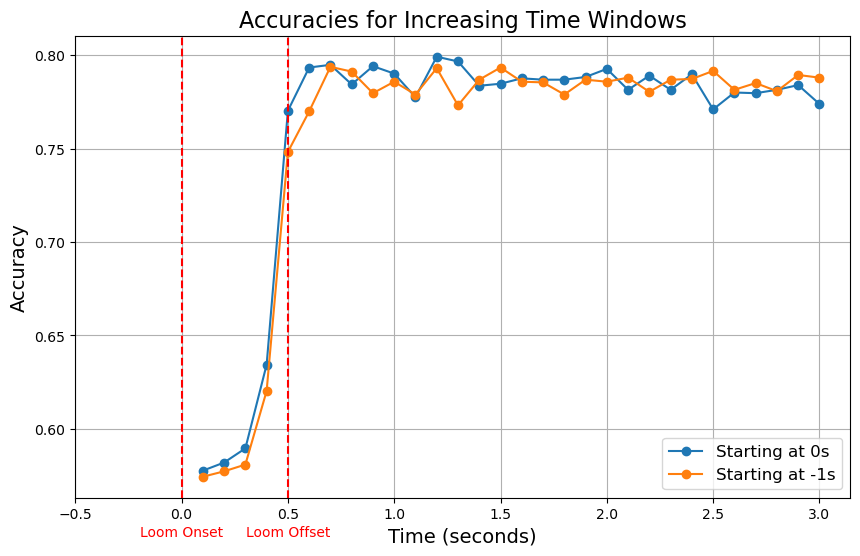

In [14]:
#PLOT : Accuracies for the Increasing Time Window

# Sample data for line 1
#data_line1 = [
#    (0.5, 0.718626),
#    (1, 0.776130),
#    (1.5, 0.774684),
#    (2, 0.770344),
#    (2.5, 0.764195),
 #   (3, 0.762749)
#]

#STARTING AT 0S 
data_line1 = [
    (0.1, 0.577577),
    (0.2, 0.581917),
    (0.3, 0.589512),
    (0.4, 0.634358),
    (0.5, 0.770344),
    (0.6, 0.793490),
    (0.7, 0.794937),
    (0.8, 0.784448),
    (0.9, 0.794213),
    (1.0, 0.790235),
    (1.1, 0.777577),
    (1.2, 0.799277),
    (1.3, 0.796745),
    (1.4, 0.783725),
    (1.5, 0.784810),
    (1.6, 0.787703),
    (1.7, 0.786980),
    (1.8, 0.786980),
    (1.9, 0.788427),
    (2.0, 0.792767),
    (2.1, 0.781555),
    (2.2, 0.789150),
    (2.3, 0.781555),
    (2.4, 0.789873),
    (2.5, 0.771067),
    (2.6, 0.780108),
    (2.7, 0.779747),
    (2.8, 0.781555),
    (2.9, 0.784087),
    (3.0, 0.773960)
]

#STARTING AT -1S 

data_line2 = [
    (0.1, 0.574322),
    (0.2, 0.577215),
    (0.3, 0.580832),
    (0.4, 0.620253),
    (0.5, 0.748282),
    (0.6, 0.769982),
    (0.7, 0.793852),
    (0.8, 0.791320),
    (0.9, 0.779747),
    (1.0, 0.785895),
    (1.1, 0.779024),
    (1.2, 0.793128),
    (1.3, 0.773237),
    (1.4, 0.786980),
    (1.5, 0.793490),
    (1.6, 0.785895),
    (1.7, 0.785533),
    (1.8, 0.779024),
    (1.9, 0.786980),
    (2.0, 0.785895),
    (2.1, 0.788065),
    (2.2, 0.780470),
    (2.3, 0.786980),
    (2.4, 0.787342),
    (2.5, 0.791682),
    (2.6, 0.781555),
    (2.7, 0.785172),
    (2.8, 0.780832),
    (2.9, 0.789512),
    (3.0, 0.788065)
]











# Sample data for line 2
#data_line2 = [
#    (0.5, 0.760579),
#    (1, 0.790235),
#    (1.5, 0.786618),
#    (2, 0.786618),
#    (2.5, 0.783725),
#    (3, 0.790235)
#]

# Extracting data for line 1
seconds_line1 = [entry[0] for entry in data_line1]
accuracy1 = [entry[1] for entry in data_line1]

# Extracting data for line 2
seconds_line2 = [entry[0] for entry in data_line2]
accuracy2 = [entry[1] for entry in data_line2]


# Plotting
plt.figure(figsize=(10, 6))

# Plot the first line with points and label
plt.plot(seconds_line1, accuracy1, marker='o', linestyle='-', label='Starting at 0s')

# Plot the second line with points and label
plt.plot(seconds_line2, accuracy2, marker='o', linestyle='-', label='Starting at -1s')

# Adding vertical lines at 0s and 0.5s with labels
plt.axvline(0, color='red', linestyle='--')
plt.text(0, plt.gca().get_ylim()[0] - 0.015, 'Loom Onset', color='red', ha='center', va='top', fontsize=10)
plt.axvline(0.5, color='red', linestyle='--')
plt.text(0.5, plt.gca().get_ylim()[0] - 0.015, 'Loom Offset', color='red', ha='center', va='top', fontsize=10)

# Labeling axes
plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Setting ticks for x-axis
plt.xticks(np.arange(-0.5, 3.1, 0.5))

# Adding legend
plt.legend(fontsize=12)

# Display the plot
plt.grid(True)
plt.title('Accuracies for Increasing Time Windows', fontsize=16)
plt.show()


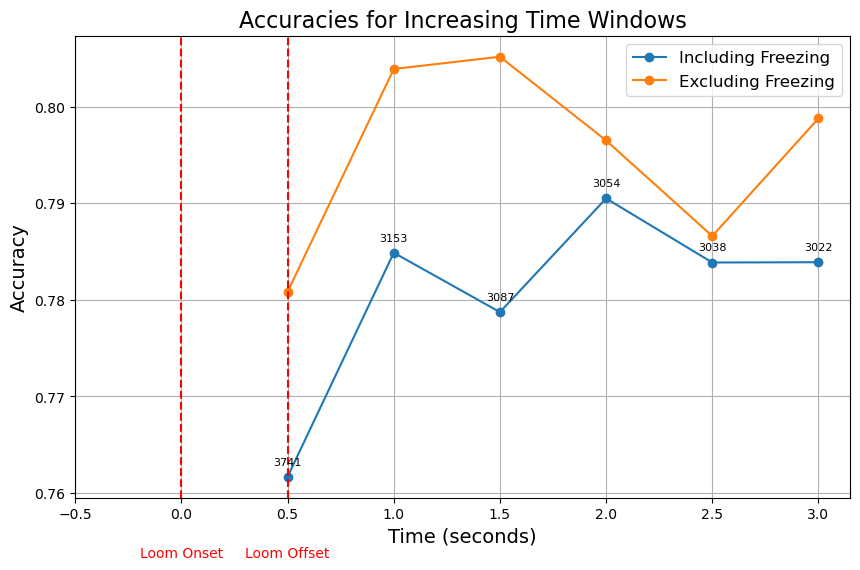

In [39]:
#PLOT : Accuracies for the Increasing Time Window, With and Without Freezing


data_line1 = [
    (-1, 0.5, 3741, 0.761693),
    (-1, 1, 3153, 0.784884),
    (-1, 1.5, 3087, 0.778737),
    (-1, 2, 3054, 0.790507),
    (-1, 2.5, 3038, 0.783873),
    (-1, 3, 3022, 0.783903)
]

data_line2 = [
    (0.5, 3741, 0.780846),
    (1, 3153, 0.803911),
    (1.5, 3087, 0.805181),
    (2, 3054, 0.796508),
    (2.5, 3038, 0.786615),
    (3, 3022, 0.798787)
]

# Extracting data for line 1
seconds_line1 = [entry[1] for entry in data_line1]
accuracy1 = [entry[3] for entry in data_line1]
middle_values1 = [int(entry[2]) for entry in data_line1]

# Extracting data for line 2
seconds_line2 = [entry[0] for entry in data_line2]
accuracy2 = [entry[2] for entry in data_line2]
middle_values2 = [entry[1] for entry in data_line2]

# Plotting
plt.figure(figsize=(10, 6))

# Plot the first line with points and label
plt.plot(seconds_line1, accuracy1, marker='o', linestyle='-', label='Including Freezing')

# Plot the second line with points and label
plt.plot(seconds_line2, accuracy2, marker='o', linestyle='-', label='Excluding Freezing')

# Adding middle values above each data point for line 1
for x, y, middle_value in zip(seconds_line1, accuracy1, middle_values1):
    plt.text(x, y + 0.001, f'{middle_value}', ha='center', va='bottom', fontsize=8)

# Adding vertical lines at 0s and 0.5s with labels
plt.axvline(0, color='red', linestyle='--')
plt.text(0, plt.gca().get_ylim()[0] - 0.005, 'Loom Onset', color='red', ha='center', va='top', fontsize=10)
plt.axvline(0.5, color='red', linestyle='--')
plt.text(0.5, plt.gca().get_ylim()[0] - 0.005, 'Loom Offset', color='red', ha='center', va='top', fontsize=10)

# Labeling axes
plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Setting ticks for x-axis
plt.xticks(np.arange(-0.5, 3.1, 0.5))

# Adding legend
plt.legend(fontsize=12)

# Display the plot
plt.grid(True)
plt.title('Accuracies for Increasing Time Windows', fontsize=16)
plt.show()




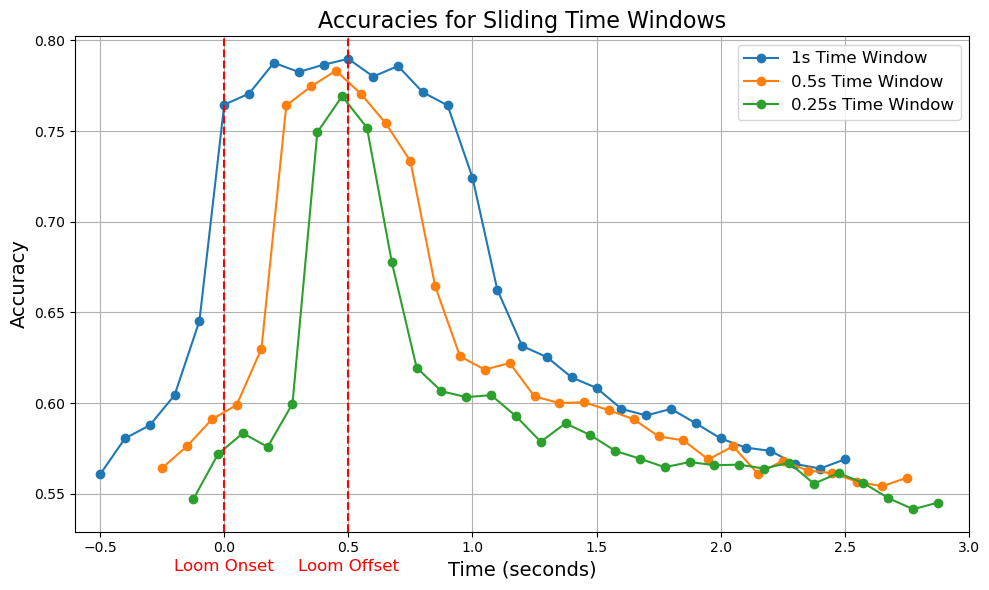

In [15]:
#PLOT : Accuracies for the Sliding Time Window

data1 = {
    'Time_Window': ['-60s:0s', '-54s:6s', '-48s:12s', '-42s:18s', '-36s:24s', '-30s:30s', '-24s:36s', '-18s:42s', '-12s:48s', '-6s:54s', 
                    '-0s:60s', '6s:66s', '12s:72s', '18s:78s', '24s:84s', '30s:90s', '36s:96s', '42s:102s', '48s:108s', '54s:114s',
                    '60s:120s', '66s:126s', '72s:132s', '78s:138s', '84s:144s', '90s:150s', '96s:156s', '102s:162s', '108s:168s', '114s:174s', '120s:180s'],
    'Accuracy': [0.560579, 0.580470, 0.587703, 0.604340, 0.645208, 0.764557, 0.770705, 0.787703, 0.782640, 0.786618, 
                 0.789873, 0.780108, 0.785895, 0.771429, 0.764195, 0.724412, 0.662568, 0.631465, 0.625316, 0.614105,
                 0.608318, 0.596745, 0.593128, 0.596745, 0.588788, 0.580470, 0.575407, 0.573599, 0.566365, 0.563834, 0.568897]
}

data2 = {
    'Time_Window': ['-30s:0s', '-24s:6s', '-18s:12s', '-12s:18s', '-6s:24s', '-0s:30s', '6s:36s', '12s:42s', '18s:48s', '24s:54s', 
                    '30s:60s', '36s:66s', '42s:72s', '48s:78s', '54s:84s', '60s:90s', '66s:96s', '72s:102s', '78s:108s', '84s:114s',
                    '90s:120s', '96s:126s', '102s:132s', '108s:138s', '114s:144s', '120s:150s', '126s:156s', '132s:162s', '138s:168s', '144s:174s', '150s:180s'],
    'Accuracy': [0.564195, 0.576130, 0.590958, 0.598915, 0.630018, 0.764195, 0.774684, 0.783363, 0.770705, 0.754430, 
                 0.733454, 0.664376, 0.625678, 0.618445, 0.622061, 0.603617, 0.600000, 0.600362, 0.596022, 0.590958,
                 0.581555, 0.579385, 0.568897, 0.576130, 0.560940, 0.568174, 0.562749, 0.561302, 0.556600, 0.554069, 0.558770]
}

# data3 = {
#     'Time_Window': [
#         '-15s:0s', '-12s:3s', '-9s:6s', '-6s:9s', '-3s:12s', '-0s:15s', '3s:18s', '6s:21s', '9s:24s', '12s:27s',
#         '15s:30s', '18s:33s', '21s:36s', '24s:39s', '27s:42s', '30s:45s', '33s:48s', '36s:51s', '39s:54s', '42s:57s',
#         '45s:60s', '48s:63s', '51s:66s', '54s:69s', '57s:72s', '60s:75s', '63s:78s', '66s:81s', '69s:84s', '72s:87s',
#         '75s:90s', '78s:93s', '81s:96s', '84s:99s', '87s:102s', '90s:105s', '93s:108s', '96s:111s', '99s:114s', '102s:117s',
#         '105s:120s', '108s:123s', '111s:126s', '114s:129s', '117s:132s', '120s:135s', '123s:138s', '126s:141s', '129s:144s', '132s:147s',
#         '135s:150s', '138s:153s', '141s:156s', '144s:159s', '147s:162s', '150s:165s', '153s:168s', '156s:171s', '159s:174s', '162s:177s',
#         '165s:180s'
#     ],
#     'Accuracy': [
#         0.546835, 0.557324, 0.571790, 0.580108, 0.583363, 0.585895, 0.575769, 0.573237, 0.599638, 0.671971,
#         0.749367, 0.761664, 0.769259, 0.750452, 0.751899, 0.721519, 0.677758, 0.652441, 0.619530, 0.612658,
#         0.606510, 0.612658, 0.603255, 0.601808, 0.604340, 0.603978, 0.592767, 0.590235, 0.578662, 0.594213,
#         0.588788, 0.581555, 0.582278, 0.573599, 0.573599, 0.569982, 0.569259, 0.576130, 0.564557, 0.567812,
#         0.567450, 0.564919, 0.565642, 0.557324, 0.566004, 0.555877, 0.563834, 0.563834, 0.567089, 0.556962,
#         0.555515, 0.549729, 0.561302, 0.556962, 0.555877, 0.564195, 0.547559, 0.551537, 0.541410, 0.547920,
#         0.545027
#     ]
# }

data3 = {
    'Time_Window': [
        '-15s:0s',  '-9s:6s', '-3s:12s', '3s:18s',  '9s:24s', 
        '15s:30s',  '21s:36s',  '27s:42s',  '33s:48s',  '39s:54s', 
        '45s:60s',  '51s:66s',  '57s:72s',  '63s:78s',  '69s:84s', 
        '75s:90s',  '81s:96s',  '87s:102s',  '93s:108s',  '99s:114s', 
        '105s:120s',  '111s:126s', '117s:132s', '123s:138s',  '129s:144s', 
        '135s:150s', '141s:156s',  '147s:162s',  '153s:168s', '159s:174s', 
        '165s:180s'
    ],
    
    'Accuracy': [
         0.546835, 0.571790,  0.583363,  0.575769, 0.599638, 
         0.749367,  0.769259, 0.751899, 0.677758,  0.619530, 
         0.606510,  0.603255,  0.604340, 0.592767,  0.578662, 
         0.588788,  0.582278,  0.573599, 0.569259,  0.564557, 
        0.567450,  0.565642,  0.566004, 0.563834,  0.567089, 
        0.555515,  0.561302,  0.555877, 0.547559, 0.541410, 
        0.545027
    ]
}



# Create DataFrames
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)

# Convert time window from frames to seconds
def convert_to_seconds(window):
    start_str, end_str = window[:-1].split(':')
    start_sec = int(start_str.split('s')[0]) if start_str else 0
    end_sec = int(end_str.split('s')[0]) if end_str else 0
    return ((start_sec + end_sec) / 2) / 60

# Apply the function to both DataFrames
df1['Time_Seconds'] = df1['Time_Window'].apply(convert_to_seconds)
df2['Time_Seconds'] = df2['Time_Window'].apply(convert_to_seconds)
df3['Time_Seconds'] = df3['Time_Window'].apply(convert_to_seconds)

# Plotting
plt.figure(figsize=(10, 6))

# Plot the data for line 1
plt.plot(df1['Time_Seconds'], df1['Accuracy'], marker='o', linestyle='-', label='1s Time Window')

# Plot the data for line 2
plt.plot(df2['Time_Seconds'], df2['Accuracy'], marker='o', linestyle='-', label='0.5s Time Window')

# Plot the data for line 3
plt.plot(df3['Time_Seconds'], df3['Accuracy'], marker='o', linestyle='-', label='0.25s Time Window')


# Adding vertical lines at 0s and 0.5s with labels
plt.axvline(0, color='red', linestyle='--')
plt.text(0, plt.gca().get_ylim()[0] - 0.015, 'Loom Onset', color='red', ha='center', va='top', fontsize=12)
plt.axvline(0.5, color='red', linestyle='--')
plt.text(0.5, plt.gca().get_ylim()[0] - 0.015, 'Loom Offset', color='red', ha='center', va='top', fontsize=12)

# Labeling axes
plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Adding legend
plt.legend(fontsize=12)

# Display the plot
plt.grid(True)
plt.title('Accuracies for Sliding Time Windows', fontsize=16)
plt.xlim(-0.6, 3)
plt.tight_layout()
plt.show()


